# Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans


# Dataset and Preprocessing

In [2]:
ratings = pd.read_csv('Small/data/ratings.csv')
movies = pd.read_csv('Small/data/movie_features.csv')
movies


,movieId,title,0,1,2,3,4,5,6,7,...,9,10,11,12,13,14,15,16,17,18
0,1,Toy Story,0.039268,0.125361,-0.749132,-0.961044,0.096545,0.193138,-0.111254,0.272728,...,0.282569,-0.187634,-0.022400,-0.087072,-0.007855,-0.071696,-0.058506,0.065733,-0.003531,0.054916
1,2,Jumanji,0.039268,0.138841,-0.648570,-1.153977,0.318046,0.215654,-0.024189,0.352185,...,0.401672,-0.154782,-0.153387,-0.388624,-0.360566,-0.258208,-0.032363,-0.000749,-0.385688,-0.080618
2,3,Grumpier Old Men,0.039268,0.111973,-0.775127,0.528985,-0.572805,-0.107470,0.016346,-0.316577,...,0.161133,0.184314,-0.323776,-0.120591,0.280047,0.028525,0.010895,-0.003964,-0.038433,-0.002496
3,4,Waiting to Exhale,0.039268,0.119104,-0.512009,0.627566,-0.250823,-0.018064,0.113547,-0.088029,...,0.192651,0.070346,-0.067178,-0.040143,0.119258,0.015443,0.027146,-0.009561,0.002256,-0.010464
4,5,Father of the Bride Part II,0.039268,0.086949,-0.813359,0.198419,-0.749539,-0.134186,-0.242839,-0.599110,...,-0.155836,-0.057572,0.093625,0.197073,-0.236524,0.021729,0.069160,0.081727,0.050081,0.039669
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9737,193581,Black Butler: Book of the Atlantic,0.039268,0.129810,-0.463801,-0.717611,0.065694,0.143417,-0.088780,-0.022175,...,0.096700,-0.118705,-0.036235,-0.134324,0.032801,0.006917,-0.247704,0.215154,0.465347,-0.044365
9738,193583,No Game No Life: Zero,0.039268,0.118566,-0.758126,-0.780131,-0.107518,0.166745,-0.126953,0.227710,...,0.266754,-0.179004,-0.047302,-0.077422,0.000020,0.063636,-0.400865,0.358892,0.435827,0.124076
9739,193585,Flint,0.039268,0.133365,0.014227,0.824729,0.393142,0.160747,0.307949,0.369068,...,0.255686,-0.157590,0.446019,0.120754,-0.202322,-0.010722,0.059648,-0.020755,0.083632,-0.026398
9740,193587,Bungo Stray Dogs: Dead Apple,0.039268,0.143438,-0.283708,-1.035880,0.431726,0.263173,-0.107562,0.067183,...,-0.024899,-0.177030,0.125750,0.114205,0.705045,0.115588,-0.026410,0.016563,0.821619,-0.036462


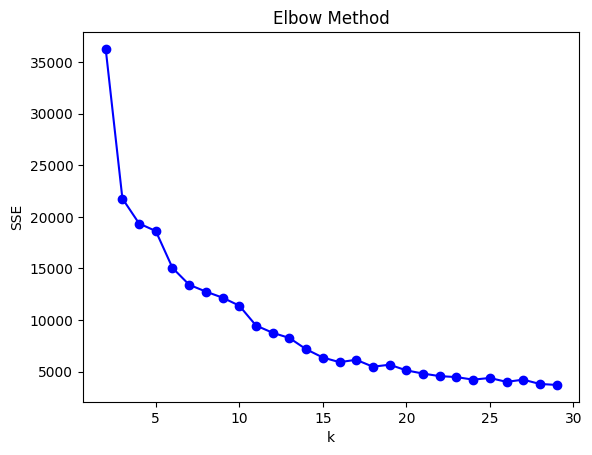

In [3]:
def plot_elbow(data: pd.DataFrame, k_range: range):
    sse = []

    for k in k_range:
        kmeans = KMeans(n_clusters=k, n_init='auto')
        kmeans.fit(data)
        sse.append(kmeans.inertia_)

    plt.plot(k_range, sse, 'bo-')
    plt.xlabel('k')
    plt.ylabel('SSE')
    plt.title('Elbow Method')
    plt.show()


plot_elbow(movies.drop(columns=['movieId', 'title']), range(2, 30))


# Recommendation

In [4]:
def recommend_movies(movies: pd.DataFrame, ratings: pd.DataFrame, n_recommendations: int, min_rating: float, n_clusters: int):
    movie_features = movies.drop(columns=['movieId', 'title'])

    # 1. Cluster the movies using k-means
    kmeans = KMeans(n_clusters=n_clusters, n_init='auto')
    movies['cluster'] = kmeans.fit_predict(movie_features)

    recommendations = []
    user_ids = ratings['userId'].unique()
    for user_id in user_ids:
        # 2. Find the cluster of movies that the user enjoys watching
        user_ratings = ratings[ratings['userId'] == user_id]
        high_rated_movies = user_ratings[user_ratings['rating'] >= min_rating]['movieId']

        # 3. Calculate the user embedding
        if len(high_rated_movies) > 0:
            user_clusters = movies[movies['movieId'].isin(high_rated_movies)]['cluster'].unique()
            highest_rated_movies = pd.DataFrame()
            for cluster in user_clusters:
                cluster_movies = movies[movies['cluster'] == cluster]
                cluster_ratings = pd.merge(cluster_movies, user_ratings, on='movieId')
                max_rating = cluster_ratings['rating'].max()
                highest_rated_cluster_movies = cluster_ratings[cluster_ratings['rating'] == max_rating]
                highest_rated_movies = pd.concat([highest_rated_movies, highest_rated_cluster_movies])
            weights = highest_rated_movies['rating'] / highest_rated_movies['rating'].sum()
            user_embedding = (highest_rated_movies.drop(columns=['movieId', 'title', 'cluster', 'userId', 'rating', 'timestamp']).values * weights.values[:, np.newaxis]).sum(axis=0)

        else:
            highest_ratings = user_ratings.nlargest(n_recommendations, 'rating')
            highest_rated_movie_ids = highest_ratings['movieId']
            highest_rated_movies = movies[movies['movieId'].isin(highest_rated_movie_ids)]
            weights = highest_ratings['rating'] / highest_ratings['rating'].sum()
            user_embedding = (highest_rated_movies.drop(columns=['movieId', 'title', 'cluster']).values * weights.values[:, np.newaxis]).sum(axis=0)

        # 4. Recommend K movies to the user based on the calculated embedding
        movies['distance'] = np.linalg.norm(movie_features - user_embedding, axis=1)
        rated_movies = user_ratings['movieId'].unique()
        recommended_ids = list(movies[~movies['movieId'].isin(rated_movies)].nsmallest(n_recommendations, 'distance')['movieId'])

        movies = movies.drop(columns='distance')
        recommendations.append({'userId': user_id, 'recommended_movies': recommended_ids})

    return pd.DataFrame(recommendations)


recommendations = recommend_movies(movies, ratings, 10, 4, 6)
recommendations.to_csv('Small/recommendations/cluster.csv')
recommendations


,userId,recommended_movies
0,1,"[117646, 55116, 4956, 4818, 5657, 6990, 4719, ..."
1,2,"[8464, 27899, 5785, 81156, 118198, 32314, 4610..."
2,3,"[60471, 1200, 161918, 1037, 1320, 2364, 2722, ..."
3,4,"[970, 496, 5666, 4956, 72142, 587, 1912, 3893,..."
4,5,"[4719, 970, 3390, 27790, 2931, 587, 4956, 5657..."
...,...,...
605,606,"[496, 3893, 144606, 4956, 45, 319, 5416, 6193,..."
606,607,"[51545, 7235, 4210, 43932, 7022, 7360, 8894, 7..."
607,608,"[59947, 70728, 27549, 459, 55116, 20, 5027, 56..."
608,609,"[20, 145, 1432, 5027, 5628, 7007, 4998, 59947,..."
